# Ambiguous preprocessing

In [1]:
import pandas as pd
import numpy as np
import json
import hashlib
from datetime import datetime
import random


In [13]:
np.random.seed(42)
random.seed(42)

df = pd.DataFrame({
    "age": np.random.uniform(low=18, high=100, size=1000),
    "size": np.random.uniform(low=1000, high=10000, size=1000),
    "price": np.random.randint(low=10000, high=100000, size=1000),
    "category": np.random.choice(['A', 'B', 'C'], size=1000)
})
df["bought_house"] = (
    (df["price"].fillna(df["price"].median()) > 50000) &
    (df["age"] > 40)
).astype(int)

# Add missingness to the price column
missing_indices = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
df.loc[missing_indices, 'price'] = np.nan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1000 non-null   float64
 1   size          1000 non-null   float64
 2   price         900 non-null    float64
 3   category      1000 non-null   object 
 4   bought_house  1000 non-null   int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 35.3+ KB


In [14]:
df

,age,size,price,category,bought_house
0,48.712290,2666.196360,84971.0,B,1
1,95.958573,5877.108526,10162.0,A,0
2,78.023503,8856.512523,44742.0,C,0
3,67.089996,7590.023978,29675.0,C,0
4,30.793529,8259.050331,83997.0,A,0
...,...,...,...,...,...
995,25.509730,6912.596406,NaN,B,0
996,93.219713,9609.531590,71610.0,B,1
997,29.219128,1620.622147,NaN,B,0
998,95.919463,1513.492490,95179.0,C,1


In [22]:
# The highest house price by age
age_price = df.groupby('age')['price'].min()
age_price

age
18.379826    91253.0
18.415050    62142.0
18.452814    23140.0
18.570075    42658.0
18.754158    91835.0
              ...   
99.221422        NaN
99.423113    78847.0
99.724221    44624.0
99.743689    99571.0
99.976849    12282.0
Name: price, Length: 1000, dtype: float64

In [ ]:
# Stable DataFrame hashing
def hash_data(df: pd.DataFrame) -> str:
    return hashlib.sha256(
        pd.util.hash_pandas_object(df, index=True).values
    ).hexdigest()

hash_data(df)


'6bde41fd8efef718e9d47572dd9f3137ab67411bb9890aef9a1bd7fe5e0de9ba'

In [777]:
# Operation base class

class Operation:
    name = "base"
    
    def __init__(self):
        pass

    def apply(self, df:pd.DataFrame) -> pd.DataFrame: # “Every operation must define how it modifies a DataFrame.”
        raise NotImplementedError
    
    def serialize(self) -> dict: # “Every operation must also know how to describe itself as data.”
        raise NotImplementedError


In [778]:
# Concrete Operations

#  1.Load Marker
class LoadData(Operation):
    name = "load_data"

    def __init__(self, shape, columns, dtypes):
        self.shape = shape
        self.columns = columns
        self.dtypes = dtypes
    
    def apply(self, df):
        return df
    
    def serialize(self):
        return{
            "op": self.name,  # "load_data"
            "shape": self.shape,
            "columns": self.columns,
            "dtypes": self.dtypes
        }

op = LoadData(df.shape, df.columns, df.dtypes)
df_new = op.apply(df)
df_new

,age,size,price,category,bought_house
0,48.712290,2666.196360,84971.0,B,1
1,95.958573,5877.108526,10162.0,A,0
2,78.023503,8856.512523,44742.0,C,0
3,67.089996,7590.023978,29675.0,C,0
4,30.793529,8259.050331,83997.0,A,0
...,...,...,...,...,...
995,25.509730,6912.596406,NaN,B,0
996,93.219713,9609.531590,71610.0,B,1
997,29.219128,1620.622147,NaN,B,0
998,95.919463,1513.492490,95179.0,C,1


In [779]:
op.serialize()

{'op': 'load_data',
 'shape': (1000, 5),
 'columns': Index(['age', 'size', 'price', 'category', 'bought_house'], dtype='object'),
 'dtypes': age             float64
 size            float64
 price           float64
 category         object
 bought_house      int32
 dtype: object}

In [780]:
# 2. Declarative Filter

class FilterRows(Operation):
    name = "filter_rows"

    def __init__(self, column, operator, value):
        self.column = column
        self.operator = operator
        self.value = value
    
    def apply(self, df):
        if self.operator == ">=":
            return df[df[self.column] >= self.value].reset_index(drop=True)
        if self.operator == "<=":
            return df[df[self.column] <= self.value].reset_index(drop=True)
        if self.operator == "==":
            return df[df[self.column] == self.value].reset_index(drop=True)
        raise ValueError("Unsupported operator")
    
    def serialize(self):
        return{
            'op': self.name,
            "column": self.column,
            "operator": self.operator,
            "value": self.value
        }

op2 = FilterRows('age', '>=', 50) # Filter age to aminimum of 50 
new_df = op2.apply(df)
new_df['age'].describe()


count    589.000000
mean      75.264420
std       14.318331
min       50.164012
25%       63.061368
50%       75.051392
75%       88.232167
max       99.976849
Name: age, dtype: float64

In [781]:
op2.serialize()

{'op': 'filter_rows', 'column': 'age', 'operator': '>=', 'value': 50}

In [782]:
# 3.Drop Columns
class DropColumns(Operation):
    name = 'drop_columns'

    def __init__(self, columns):
        self.columns = columns
    
    def apply(self, df):
        return df.drop(columns = self.columns, axis = 1)
    
    def serialize(self):
        return{
            "op": self.name,
            "columns": self.columns           
        }

op3 = DropColumns(['size'])
df_new = op3.apply(df)
df_new.columns

Index(['age', 'price', 'category', 'bought_house'], dtype='object')

In [783]:
op3.serialize()

{'op': 'drop_columns', 'columns': ['size']}

In [784]:
# 4. Mean imputation
class ImputeMean(Operation):
    name = "impute_mean"

    def __init__(self, column, mean_value):
        self.column = column
        self.mean_value = mean_value
    
    def apply(self, df):
        df = df.copy()
        df[self.column] = df[self.column].fillna(self.mean_value)
        return df
    
    def serialize(self):
        return{
            "op": self.name,
            "column": self.column,
            "mean_value": self.mean_value
        }

op4 = ImputeMean(['price'], df['price'].mean())
df_new = op4.apply(df)
print("Before Imputation: ")
print(df.isnull().sum())
print("\nAfter Imputation: ")
print(df_new.isnull().sum())

Before Imputation: 
age               0
size              0
price           100
category          0
bought_house      0
dtype: int64

After Imputation: 
age             0
size            0
price           0
category        0
bought_house    0
dtype: int64


In [785]:
# 5. Normalizer

class Normalization(Operation):
    name = 'normalize'

    def __init__(self, column, normalizer):
        self.column = column
        self.normalizer = normalizer
    
    def apply(self, df):
        sc = self.normalizer
        df = df.copy()
        df[self.column] = sc.fit_transform(df[self.column])
        return df
    
    def serialize(self):
        return{
            "op": self.name,
            "column": self.column,
            "normalizer": type(self.normalizer).__name__
        }

from sklearn.preprocessing import StandardScaler
op6 = Normalization(['price'], StandardScaler())
df_new = op6.apply(df)
df_new['price']

0      1.143607
1     -1.697340
2     -0.384130
3     -0.956314
4      1.106619
         ...   
995         NaN
996    0.636210
997         NaN
998    1.531266
999   -1.126523
Name: price, Length: 1000, dtype: float64

In [786]:
op6.serialize()

{'op': 'normalize', 'column': ['price'], 'normalizer': 'StandardScaler'}

In [787]:
# 6. One hot encoding

class Ohe(Operation):
    name = 'one_hot_encode'

    def __init__(self, column, categories):
        self.column = column
        self.categories = categories
    
    def apply(self, df):
        df = df.copy()
        df = pd.get_dummies(df, columns=[self.column])
        return df
    
    def serialize(self):
        return{
            "op":self.name,
            "column": self.column,
            "categories": self.categories
        }
    
op7 = Ohe('category', df['category'].unique())
df_new = op7.apply(df)
df_new


,age,size,price,bought_house,category_A,category_B,category_C
0,48.712290,2666.196360,84971.0,1,False,True,False
1,95.958573,5877.108526,10162.0,0,True,False,False
2,78.023503,8856.512523,44742.0,0,False,False,True
3,67.089996,7590.023978,29675.0,0,False,False,True
4,30.793529,8259.050331,83997.0,0,True,False,False
...,...,...,...,...,...,...,...
995,25.509730,6912.596406,NaN,0,False,True,False
996,93.219713,9609.531590,71610.0,1,False,True,False
997,29.219128,1620.622147,NaN,0,False,True,False
998,95.919463,1513.492490,95179.0,1,False,False,True


In [788]:
op7.serialize()

{'op': 'one_hot_encode',
 'column': 'category',
 'categories': array(['B', 'A', 'C'], dtype=object)}

In [789]:
# 7. Order-sensitive filter (mean-dependent)
class FilterAboveMeanPrice(Operation):
    name = "filter_above_mean_price"

    def apply(self, df):
        mean_price = df["price"].mean()
        return df[df["price"] > mean_price].reset_index(drop=True)

    def serialize(self):
        return {
            "op": self.name
        }


In [790]:
# Record Audit Trials

class AuditTrialRecorder:
    def __init__(self, dataframe, name = "experiment"):
        self.name = name
        self.original_df = dataframe.copy()
        self.current_df = dataframe.copy()
        self.operations = []
        self.hashes = []

        self._record(              # _record means this method is internal to the class.It is not part of the public interface.”
            LoadData(
                shape=dataframe.shape,
                columns=list(dataframe.columns),
                dtypes={c: str(t) for c, t in dataframe.dtypes.items()}
            ))
        
    def _record(self, operation: Operation):
        self.operations.append(operation) 
        self.hashes.append(hash_data(self.current_df))

    def filter_rows(self, column, operator, value):
        op = FilterRows(column, operator, value)
        self.current_df = op.apply(self.current_df)
        self._record(op)
        return self

    def drop_columns(self, columns):
        op = DropColumns(columns)
        self.current_df = op.apply(self.current_df)
        self._record(op)
        return self

    def impute_mean(self, column):
        mean_val = self.current_df[column].mean()
        op = ImputeMean(column, mean_val)
        self.current_df = op.apply(self.current_df)
        self._record(op)
        return self

    def normalize_column(self, column):
        scaler = StandardScaler()
        scaler.fit(self.current_df[[column]])
        op = Normalization([column], scaler)
        self.current_df = op.apply(self.current_df)
        self._record(op)
        return self

    def one_hot_encode(self, column):
        categories = sorted(
            pd.get_dummies(self.current_df[column], prefix=column).columns
        )
        op = Ohe(column, categories)
        self.current_df = op.apply(self.current_df)
        self._record(op)
        return self
    
    def filter_above_mean_price(self):
        op = FilterAboveMeanPrice()
        self.current_df = op.apply(self.current_df)
        self._record(op)
        return self

    
    # Deterministic replay and verification 
    """
    Replay:
        - starts from raw data
        - reapplies every operation in order
        - produces a new dataset
    This answers: Can someone else regenerate the dataset exactly?
    """
    def replay(self):
        df = self.original_df.copy()
        for op in self.operations[1:]:
            df = op.apply(df)
        return df

    def verify_reproducibility(self):
        replayed_df = self.replay()
        return hash_data(replayed_df) == hash_data(self.current_df)
    
    # Export Audit Trial
    def export_audit_trail(self, filename=None):
        if filename is None:
            filename = "./audit_trails/audit_trial.json"
        trail = {
            "experiment": self.name,
            "created": datetime.now().isoformat(),
            "operations": [op.serialize() for op in self.operations],
            "final_hash": hash_data(self.current_df),
            "final_shape": self.current_df.shape,
            "final_columns": list(self.current_df.columns)
        }
        with open(filename, "w") as f:
            json.dump(trail, f, indent=2)
        return trail



In [791]:
audit = AuditTrialRecorder(df, name="house_price_data_analysis")

audit.filter_rows("age", ">=", 21)
audit.impute_mean("price")
audit.impute_mean("size")
audit.normalize_column("price")
audit.one_hot_encode("category")

print("Reproducible:", audit.verify_reproducibility())
audit.export_audit_trail()



Reproducible: True


{'experiment': 'house_price_data_analysis',
 'created': '2025-12-22T00:47:30.401668',
 'operations': [{'op': 'load_data',
   'shape': (1000, 5),
   'columns': ['age', 'size', 'price', 'category', 'bought_house'],
   'dtypes': {'age': 'float64',
    'size': 'float64',
    'price': 'float64',
    'category': 'object',
    'bought_house': 'int32'}},
  {'op': 'filter_rows', 'column': 'age', 'operator': '>=', 'value': 21},
  {'op': 'impute_mean', 'column': 'price', 'mean_value': 54786.54282407407},
  {'op': 'impute_mean', 'column': 'size', 'mean_value': 5595.867848997642},
  {'op': 'normalize', 'column': ['price'], 'normalizer': 'StandardScaler'},
  {'op': 'one_hot_encode',
   'column': 'category',
   'categories': ['category_A', 'category_B', 'category_C']}],
 'final_hash': 'b766b95f65a7ed1eef96d0d1d05f1a67f56b9d2c38192920fc60307a99c286e2',
 'final_shape': (961, 7),
 'final_columns': ['age',
  'size',
  'price',
  'bought_house',
  'category_A',
  'category_B',
  'category_C']}

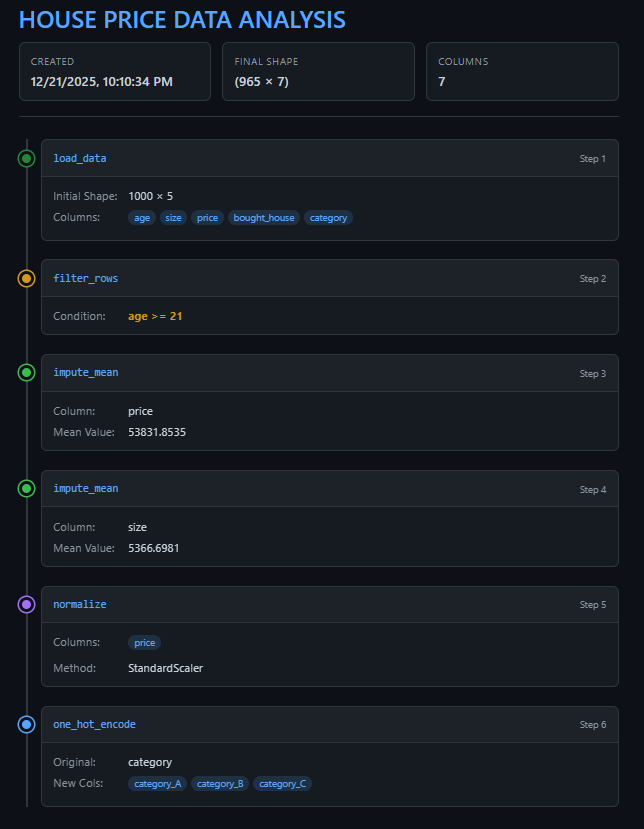

# COMPLETE EXPERIMENT: PREPROCESSING-INDUCED VARIANCE

We will produce three preprocessing paths:

- Path A: Filter → Impute → Normalize → OHE
- Path B: Impute → Filter → Normalize → OHE
- Path C: Filter → Normalize → Impute → OHE

In [792]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [793]:
class Modeling:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.results = []
    
    def train(self):
        xtrain, xtest, ytrain, ytest = train_test_split(self.X, self.y, test_size = 0.3, random_state=42)
        
        sc = StandardScaler()
        xtrain = sc.fit_transform(xtrain)
        xtest = sc.transform(xtest)

        models = [
            LogisticRegression(random_state=42),
            XGBClassifier(random_state=42),
            RandomForestClassifier(random_state=42)
            ]
        
        for i in range(len(models)):
            name = models[i].__class__.__name__
            ypred = models[i].fit(xtrain, ytrain).predict(xtest)
            evaluation = classification_report(ytest, ypred)
            accuracy = accuracy_score(ytest, ypred)
            print(f"----{models[i]}-----")
            print("Results", evaluation)
            self.results.append([name, accuracy])

data = df.copy()
# bought_house is already numeric (0 and 1), no mapping needed
# data['bought_house'] = data['bought_house'].map({
#     'yes': 1,
#     'No': 0
# })

# No need to drop rows since bought_house is already clean
# data = data.dropna(subset=['bought_house'])

data = pd.get_dummies(data, columns=['category'])
numeric_cols = data.select_dtypes(include="number").columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Convert boolean columns to integers
bool_cols = data.select_dtypes(include="bool").columns
data[bool_cols] = data[bool_cols].astype(int)

trainer = Modeling(data.drop('bought_house', axis =1), data.bought_house)
trainer.train()

----LogisticRegression(random_state=42)-----
Results               precision    recall  f1-score   support

           0       0.86      0.92      0.89       186
           1       0.86      0.76      0.81       114

    accuracy                           0.86       300
   macro avg       0.86      0.84      0.85       300
weighted avg       0.86      0.86      0.86       300

----XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missi

In [794]:
results=trainer.results
print(results)

[['LogisticRegression', 0.8633333333333333], ['XGBClassifier', 0.9666666666666667], ['RandomForestClassifier', 0.97]]


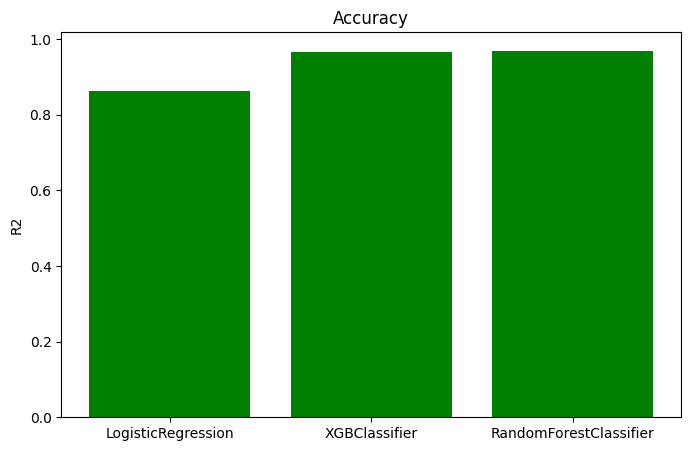

In [795]:
import matplotlib.pyplot as plt


#Extract names, r2s, and maes
names = [row[0] for row in results]
acuracy = [row[1] for row in results]

#R2 plot
plt.figure(figsize = (8,5))
plt.bar(names,acuracy, color = 'g')
plt.title("Accuracy")
plt.ylabel("R2")
plt.show()

In [796]:
# Helper: train model and return accuracy

def train_and_evaluate(df: pd.DataFrame, seed=0):
    X = df.drop(columns=["bought_house"])
    # Convert bought_house to binary: 1 for "yes"/1, 0 otherwise
    y = (df["bought_house"].astype(str).str.lower() == "yes").astype(int)
    
    # Ensure we have both classes in the dataset
    if len(y.unique()) < 2:
        return 0.5 
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed, stratify=y
    )

    model = RandomForestClassifier(max_iter=1000, random_state=seed)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

## Define ambiguous preprocessing paths

In [797]:
def run_path(path_name, df):
    audit = AuditTrialRecorder(df, name=path_name)

    if path_name == "Path_A":
        audit.impute_mean("price")
        audit.filter_above_mean_price()
        audit.normalize_column("price")

    elif path_name == "Path_B":
        audit.filter_above_mean_price()
        audit.impute_mean("price")
        audit.normalize_column("price")

    elif path_name == "Path_C":
        audit.impute_mean("price")
        audit.normalize_column("price")
        audit.filter_above_mean_price()

    audit.one_hot_encode("category")

    final_df = audit.current_df

    X = final_df.drop(columns=["bought_house"])
    y = final_df["bought_house"]

    return X, y


In [798]:
# Use a variance-sensitive model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def evaluate_paths(df, seeds=10):
    results = { "Path_A": [], "Path_B": [], "Path_C": [] }

    for seed in range(seeds):
        for path in results.keys():
            X, y = run_path(path, df)

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=seed
            )

            model = RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                random_state=seed
            )

            model.fit(X_train, y_train)
            acc = model.score(X_test, y_test)

            results[path].append(acc)

    return results

In [799]:
results = evaluate_paths(df)

mean_acc = {k: np.mean(v) for k, v in results.items()}
all_accs = np.concatenate(list(results.values()))

print("Mean accuracies per path:", mean_acc)
print("Overall mean accuracy:", np.mean(all_accs))
print("Variance due to preprocessing ambiguity:", np.var(all_accs))


Mean accuracies per path: {'Path_A': 0.9371257485029941, 'Path_B': 1.0, 'Path_C': 0.9371257485029941}
Overall mean accuracy: 0.9580838323353295
Variance due to preprocessing ambiguity: 0.00099441834893088


C:\Users\adm\AppData\Local\Temp\ipykernel_10712\1968513197.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(path_accuracies, labels=path_names)


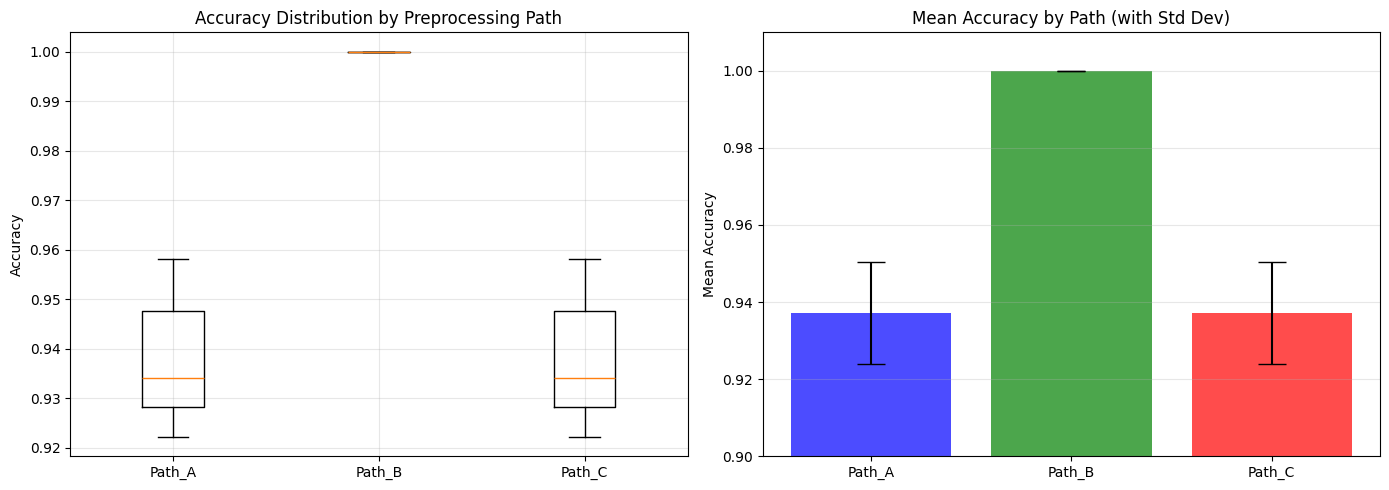


PREPROCESSING PATH VARIANCE ANALYSIS

Path_A:
  Mean Accuracy: 0.9371
  Std Dev:       0.0132
  Min:           0.9222
  Max:           0.9581

Path_B:
  Mean Accuracy: 1.0000
  Std Dev:       0.0000
  Min:           1.0000
  Max:           1.0000

Path_C:
  Mean Accuracy: 0.9371
  Std Dev:       0.0132
  Min:           0.9222
  Max:           0.9581

Overall Variance (across all paths): 0.000994


In [800]:
# Visualize the preprocessing path variance

import matplotlib.pyplot as plt

# Extract accuracies for each path
path_names = list(results.keys())
path_accuracies = [results[path] for path in path_names]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Box plot of accuracies across paths
axes[0].boxplot(path_accuracies, labels=path_names)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy Distribution by Preprocessing Path")
axes[0].grid(True, alpha=0.3)

# Plot 2: Mean accuracy per path with error bars
means = [np.mean(accs) for accs in path_accuracies]
stds = [np.std(accs) for accs in path_accuracies]
axes[1].bar(path_names, means, yerr=stds, capsize=10, alpha=0.7, color=['blue', 'green', 'red'])
axes[1].set_ylabel("Mean Accuracy")
axes[1].set_title("Mean Accuracy by Path (with Std Dev)")
axes[1].set_ylim([0.9, 1.01])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PREPROCESSING PATH VARIANCE ANALYSIS")
print("="*60)
for path in path_names:
    accs = results[path]
    print(f"\n{path}:")
    print(f"  Mean Accuracy: {np.mean(accs):.4f}")
    print(f"  Std Dev:       {np.std(accs):.4f}")
    print(f"  Min:           {np.min(accs):.4f}")
    print(f"  Max:           {np.max(accs):.4f}")

print(f"\nOverall Variance (across all paths): {np.var(all_accs):.6f}")

In [801]:
import os
os.makedirs("./audit_trails", exist_ok=True)

# Create audit recorders for each path
audit_A = AuditTrialRecorder(df, name="Path_A")
audit_A.impute_mean("price")
audit_A.filter_above_mean_price()
audit_A.normalize_column("price")
audit_A.one_hot_encode("category")

audit_B = AuditTrialRecorder(df, name="Path_B")
audit_B.filter_above_mean_price()
audit_B.impute_mean("price")
audit_B.normalize_column("price")
audit_B.one_hot_encode("category")

audit_C = AuditTrialRecorder(df, name="Path_C")
audit_C.impute_mean("price")
audit_C.normalize_column("price")
audit_C.filter_above_mean_price()
audit_C.one_hot_encode("category")

# Verify reproducibility
assert audit_A.verify_reproducibility()
assert audit_B.verify_reproducibility()
assert audit_C.verify_reproducibility()

# Export audit trails
audit_A.export_audit_trail("./audit_trails/audit_A.json")
audit_B.export_audit_trail("./audit_trails/audit_B.json")
audit_C.export_audit_trail("./audit_trails/audit_C.json")

print("All audit trails verified and exported successfully!")


All audit trails verified and exported successfully!
